In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

pd.set_option('display.float_format', '{:.4f}'.format)

# **Ejercicio 1:** Equity

In [2]:
tickers = ['KO','PEP','V','MA','XOM','CVX','JPM','BAC']

positions = {
    'KO': -125312,
    'PEP': 59350,
    'V': 30660,
    'MA': -18804,
    'XOM': -66386,
    'CVX': 54504,
    'JPM': 33003,
    'BAC': -189680
}

data = yf.download(tickers, start='2024-02-12', end='2026-02-13', progress=False)['Close']
returns = data.pct_change().dropna()

In [3]:
data

Ticker,BAC,CVX,JPM,KO,MA,PEP,V,XOM
Date,,,,,,,,
2024-02-12,32.0435,139.3395,168.4081,56.2705,453.4999,158.9637,271.0048,95.5977
2024-02-13,31.2143,137.9835,166.9423,55.9406,455.2301,157.3518,271.7339,94.7747
2024-02-14,31.5765,138.3591,168.6380,55.8841,459.9064,156.0846,273.4580,94.3071
2024-02-15,32.4724,143.0643,172.3168,55.9878,465.9272,156.4014,276.8275,97.0098
2024-02-16,32.4915,143.2218,171.5120,55.9783,462.8130,154.9665,274.4432,97.0098
...,...,...,...,...,...,...,...,...
2026-02-06,56.5300,180.8600,322.4000,79.0300,548.7400,170.4900,330.8976,148.0631
2026-02-09,56.4100,182.6000,322.1000,77.9700,535.3300,166.4700,324.9100,150.2088
2026-02-10,55.3900,182.2600,318.2800,76.8100,540.3900,166.9700,328.1700,150.5863


In [4]:
latest_prices = data.iloc[-1]

# Valor de cada posición
values = pd.Series(positions) * latest_prices

# Valor total del portafolio
portfolio_value = sum([abs(x) for x in values.tolist()])

# Pesos de cada activo
weights = values / portfolio_value
weights = weights.to_frame(name='Peso (%)')
weights * 100

,Peso (%)
BAC,-12.5268
CVX,12.5011
JPM,12.5595
KO,-12.4484
MA,-12.4719
PEP,12.4782
V,12.4983
XOM,-12.5158


In [5]:
# Retornos del portafolio
portfolio_returns = returns.dot(weights)

# P&L
portfolio_pnl = portfolio_returns * portfolio_value

VaR_95 = np.percentile(portfolio_pnl, 5)
print("VaR histórico 1 día 95%:", VaR_95)

VaR histórico 1 día 95%: -315352.82759348216


**Por qué se sigue teniendo riesgo?**

Aunque el portafolio tiene posiciones largas y cortas en igual proporción, el riesgo no desaparece porque la cobertura no es perfecta. Las acciones dentro de cada par no están perfectamente correlacionadas, sus volatilidades son distintas y reaccionan de forma diferente a factores macroeconómicos.

In [6]:
volume = yf.download(tickers, start='2025-11-12', end='2026-02-13', progress=False)['Volume']
avg_volume = volume.mean()

In [35]:
liquidity_check = {}

for ticker in tickers:
    shares = abs(positions[ticker])
    max_daily_trade = 0.10 * avg_volume[ticker]
    days_needed = shares / max_daily_trade
    liquidity_check[ticker] = days_needed

liquidity = pd.DataFrame.from_dict(liquidity_check, orient='index', columns=['Days to Liquidate'])
liquidity['Cumple ?'] = liquidity['Days to Liquidate'] < 2

liquidity

,Days to Liquidate,Cumple ?
KO,0.0698,True
PEP,0.0703,True
V,0.0416,True
MA,0.0551,True
XOM,0.0364,True
CVX,0.0518,True
JPM,0.0314,True
BAC,0.0494,True


**Conclusión:** Todas las posiciones pueden liquidarse dentro de 2 días

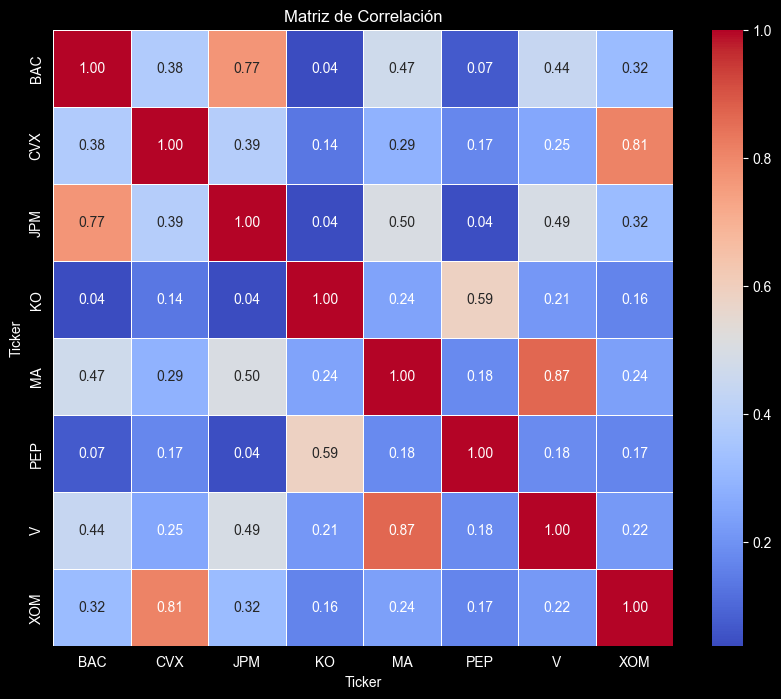

In [8]:
corr_matrix = returns.corr()
plt.figure(figsize=(10,8))

sns.heatmap(corr_matrix,
            annot=True,
            cmap='coolwarm',
            fmt=".2f",
            linewidths=0.5)

plt.title("Matriz de Correlación")
plt.show()

**¿Cómo modificaría las ponderaciones en cada par buscando reducir el riesgo aun más?**  



In [9]:
alt = {
    'BAC': -0.10,
    'CVX':  0.15,
    'JPM':  0.10,
    'KO':  -0.05,
    'MA':  -0.20,
    'PEP':  0.05,
    'V':    0.20,
    'XOM': -0.15
}

weights_alt = pd.DataFrame.from_dict(alt, orient='index', columns=['w'])
portfolio_returns = returns.dot(weights_alt)
portfolio_pnl = portfolio_returns * portfolio_value

VaR_95 = np.percentile(portfolio_pnl, 5)
print("VaR histórico 1 día 95% con nuevas ponderaciones:", VaR_95)

VaR histórico 1 día 95% con nuevas ponderaciones: -301656.3699072531


**Razonamiento:** Con base en la matriz de correlación observada, se decidió modificar las ponderaciones del portafolio asignando mayor peso a aquellos pares que presentan correlaciones más altas (por ejemplo, MA–V y CVX–XOM), ya que una mayor correlación implica que ambos activos tienden a moverse de manera más similar, reduciendo la volatilidad del spread entre la posición larga y la corta. En lugar de mantener ponderaciones uniformes, se incrementó la exposición en estos pares más correlacionados y se redujo en aquellos con menor relación estadística, buscando una cobertura más eficiente. Como resultado de este ajuste, el VaR histórico a 1 día al 95% disminuyó aproximadamente en 15,000 dólares (de alrededor de -315,350 a -301,660), evidenciando una reducción efectiva del riesgo del portafolio sin alterar su estructura long-short ni su exposición absoluta total.

# **Ejercicio 2:** Divisas

In [10]:
usd = pd.read_excel('USDMXN.xlsx', skiprows=2)
eur = pd.read_excel('EURMXN.xlsx', skiprows=2)

In [11]:
for col in ['Bid', 'Ask', 'Mid']:
    usd[col] = pd.to_numeric(usd[col], errors='coerce')
    eur[col] = pd.to_numeric(eur[col], errors='coerce')

usd['Date'] = pd.to_datetime(usd['Date'])
eur['Date'] = pd.to_datetime(eur['Date'])

usd = usd.sort_values('Date').reset_index(drop=True)
eur = eur.sort_values('Date').reset_index(drop=True)

In [12]:
# RENDIMIENTOS ARITMÉTICOS CON MID
usd['rend'] = usd['Mid'].pct_change()
eur['rend'] = eur['Mid'].pct_change()

usd = usd.dropna(subset=['rend']).reset_index(drop=True)
eur = eur.dropna(subset=['rend']).reset_index(drop=True)

N = 500
usd_500 = usd.tail(N).reset_index(drop=True)
eur_500 = eur.tail(N).reset_index(drop=True)

In [13]:
# MERGE Y PONDERACIONES (CONVERTIDO A MXN)
merged = pd.merge(usd_500[['Date','rend','Bid','Ask','Mid']],
                  eur_500[['Date','rend','Bid','Ask','Mid']],
                  on='Date', suffixes=('_usd','_eur'))

spot_usd = usd.iloc[-1]['Mid']
spot_eur = eur.iloc[-1]['Mid']

valor_usd_mxn = 4_000_000 * spot_usd
valor_eur_mxn = 3_000_000 * spot_eur
total = valor_usd_mxn + valor_eur_mxn

w_usd = -valor_usd_mxn / total
w_eur =  valor_eur_mxn / total

In [14]:
print(f"Valor USDMXN en MXN: ${valor_usd_mxn:,.2f}")
print(f"Valor EURMXN en MXN: ${valor_eur_mxn:,.2f}")
print(f"Total portafolio MXN: ${total:,.2f}")
print(f"Ponderaciones: USDMXN={w_usd:.4f}, EURMXN={w_eur:.4f}")

Valor USDMXN en MXN: $68,747,000.00
Valor EURMXN en MXN: $61,279,365.00
Total portafolio MXN: $130,026,365.00
Ponderaciones: USDMXN=-0.5287, EURMXN=0.4713


In [15]:
# RENDIMIENTO DEL PORTAFOLIO
merged['rend_port'] = w_usd * merged['rend_usd'] + w_eur * merged['rend_eur']

In [16]:
# VaR HISTÓRICO AL 95%
var_pct = np.percentile(merged['rend_port'], 5)
var_dinero = var_pct * total

print(f"\nVaR en %:{var_pct*100:.4f}%")
print(f"VaR en MXN: ${var_dinero:,.2f}")


VaR en %:-0.3396%
VaR en MXN: $-441,568.98


In [17]:
# COSTO DE LIQUIDEZ
merged['spread_usd'] = (merged['Ask_usd'] - merged['Bid_usd']) / merged['Mid_usd']
merged['spread_eur'] = (merged['Ask_eur'] - merged['Bid_eur']) / merged['Mid_eur']

w_abs_usd = valor_usd_mxn / total
w_abs_eur = valor_eur_mxn / total
merged['spread_port'] = w_abs_usd * merged['spread_usd'] + w_abs_eur * merged['spread_eur']

mu_spread = merged['spread_port'].mean()
sigma_spread = merged['spread_port'].std()
z = norm.ppf(0.95)

lc = 0.5 * (mu_spread + z * sigma_spread)

In [18]:
print(f"\nμ spread:  {mu_spread:.6f}")
print(f"σ spread:  {sigma_spread:.6f}")
print(f"z (95%):   {z:.4f}")
print(f"LC = 0.5*(μ + z*σ) = {lc:.6f}")


μ spread:  0.000333
σ spread:  0.000084
z (95%):   1.6449
LC = 0.5*(μ + z*σ) = 0.000236


In [19]:
# L-VaR
lvar_pct = var_pct - lc
lvar_dinero = lvar_pct * total

print(f"\nL-VaR en %:      {lvar_pct:.6f} ({lvar_pct*100:.4f}%)")
print(f"L-VaR en MXN:    ${lvar_dinero:,.2f}")


L-VaR en %:      -0.003632 (-0.3632%)
L-VaR en MXN:    $-472,227.36


In [20]:
# STRESS TEST
mu_port = merged['rend_port'].mean()
sigma_port = merged['rend_port'].std()
stress_3s = mu_port - 3 * sigma_port

lc_stress = 0.5 * (mu_spread + 3 * sigma_spread)

lvar_stress = stress_3s - lc_stress
lvar_stress_dinero = lvar_stress * total

print(f"STRESS TEST - L-VaR con z=3:")
print(f"  L-VaR stress en %: {lvar_stress:.6f}")
print(f"  L-VaR stress en MXN: ${lvar_stress_dinero:,.2f}")

STRESS TEST - L-VaR con z=3:
  L-VaR stress en %: -0.006963
  L-VaR stress en MXN: $-905,310.86


El L-VaR de la mesa de divisas al cierre del 12 de febrero nos dio una pérdida máxima esperada de 472,227 pesos al 95% de confianza. Considerando que el límite diario para esta área es de 6 millones de pesos, la mesa sí cumple el límite y con mucho espacio de sobra.

El portafolio en total vale alrededor de 130 millones de pesos (68.7M del USDMXN y 61.3M del EURMXN), pero el riesgo sale bajo porque las dos posiciones van en direcciones opuestas. Al estar corto en dólares y largo en euros, los movimientos del peso se compensan parcialmente entre una posición y la otra, lo cual reduce bastante la volatilidad del portafolio combinado.

El costo de liquidez que se le sumó al VaR fue de apenas $30,658 pesos, pasando de 441,569 a 472,227. Esto se debe a que ambos cruces son muy líquidos y sus spreads son muy chicos, entonces el impacto de tener que liquidar las posiciones en el mercado sería mínimo.

Para el el stress test hicimos dos ejercicios. Con 3 sigmas obtuvimos una pérdida de $867,228 y revisando los peores días históricos, el más fuerte fue el 4 de abril de 2025 con una pérdida de 969,616. Aun así, ni el peor escenario se acerca al límite de 6 millones, lo que confirma que la mesa tiene un perfil de riesgo bastante controlado.

# **Ejercicio 3:** Tasas

**Usando tasas yield genéricas con método de atajo**

In [21]:
df = pd.read_excel('Generic Yields.xlsx')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Limpiar datos
cols = df.columns.drop('Date')
df[cols] = df[cols].replace(',', '.', regex=True).astype(float)
df = df.sort_values('Date')
df

,Date,5Y,10Y,20Y
0,2025-02-28,9.2500,9.4600,9.9400
1,2025-03-03,9.2100,9.4400,9.9600
2,2025-03-04,9.3000,9.5700,10.1000
3,2025-03-05,9.1800,9.4600,10.0100
4,2025-03-06,9.1900,9.4300,10.0500
...,...,...,...,...
236,2026-02-06,8.2400,8.7800,9.2300
237,2026-02-09,8.2400,8.7900,9.2100
238,2026-02-10,8.1600,8.7100,9.1900
239,2026-02-11,8.1500,8.7200,9.1700


In [22]:
params = pd.DataFrame(columns=['5Y', '10Y', '20Y'])
params.loc['monto'] = [100_000_000, -50_000_000, 25_000_000]
params.loc['price'] = [98.4898, 109.0769, 89.2815]
params.loc['pv01'] = [98.5318, 109.1503, 89.3674]
params.loc['titulos'] = params.loc['monto'] / params.loc['price']

valor_total = sum([abs(x) for x in params.loc['monto']])

params.loc['delta'] = params.loc['pv01'] - params.loc['price']
params.loc['delta_pos'] = params.loc['delta'] * params.loc['titulos']
params.loc['ponderacion'] = params.loc['monto'] / valor_total

params

,5Y,10Y,20Y
monto,100000000.0000,-50000000.0000,25000000.0000
price,98.4898,109.0769,89.2815
pv01,98.5318,109.1503,89.3674
titulos,1015333.5675,-458392.1985,280013.2166
delta,0.0420,0.0734,0.0859
delta_pos,42644.0098,-33645.9874,24053.1353
ponderacion,0.5714,-0.2857,0.1429


In [23]:
pl = pd.DataFrame()

pl['d5Y'] = df['5Y'].diff().dropna() * 100
pl['d10Y'] = df['10Y'].diff().dropna() * 100
pl['d20Y'] = df['20Y'].diff().dropna() * 100

pl['P&L 5Y'] = - pl['d5Y'] * params.loc['delta_pos', '5Y']
pl['P&L 10Y'] = - pl['d10Y'] * params.loc['delta_pos', '10Y']
pl['P&L 20Y'] = - pl['d20Y'] * params.loc['delta_pos', '20Y']

pl['P&L port'] = pl['P&L 5Y'] + pl['P&L 10Y'] + pl['P&L 20Y']

VaR_975_at = np.percentile(pl['P&L port'], 2.5)
print("VaR histórico 1 día 97.5% de bonos:", VaR_975_at)

VaR histórico 1 día 97.5% de bonos: -343842.6539117506


**Full Valuation Method**

In [24]:
df2 = pd.read_excel('Precios_Bonos.xlsx')
df2['Date'] = pd.to_datetime(df2['Date'])
df2 = df2.sort_values('Date')

In [25]:
ret = df2[['Precio_5Y', 'Precio_10Y', 'Precio_20Y']].pct_change().dropna()

w5 = params.loc['ponderacion', '5Y']
w10 = params.loc['ponderacion', '10Y']
w20 = params.loc['ponderacion', '20Y']

ret['Portfolio'] = (
    w5  * ret['Precio_5Y'] +
    w10 * ret['Precio_10Y'] +
    w20 * ret['Precio_20Y']
)

In [26]:
VaR_975 = np.percentile(ret['Portfolio'], 2.5) * valor_total
print("VaR histórico 1 día 97.5% con Full Valuation Method:", VaR_975)

VaR histórico 1 día 97.5% con Full Valuation Method: -330464.1388793553


La diferencia entre el VaR obtenido mediante el método de “atajo” y el método de Full Valuation se explica porque el primero utiliza una aproximación lineal basada en una sensibilidad fija del precio ante cambios en la tasa (PV01), asumiendo que la relación precio–yield es constante en el tiempo. En cambio, el método de valuación completa recalcula diariamente el precio exacto del bono utilizando los precios históricos observados, incorporando la no linealidad de la relación precio–yield y permitiendo que la sensibilidad cambie con el nivel de tasas y el tiempo al vencimiento.

In [27]:
dif = (VaR_975_at - VaR_975) / VaR_975 * 100

print("La diferencia entre ambas metodologías es:", dif, ' %' )
print("En bruto:", abs(VaR_975 - VaR_975_at))

La diferencia entre ambas metodologías es: 4.048401462792153  %
En bruto: 13378.515032395313


#### Estrategias

-Las siguientes estrategias se utilizan en la administración del riesgo de tasas de interés y se basan en cambios en la forma de la curva de rendimiento. La curva de rendimiento representa los rendimientos de los bonos en función de sus plazos de vencimiento. Es un indicador económico que refleja las expectativas del mercado sobre el crecimiento económico futuro, la inflación y la política monetaria.

**¿Que es una estrategia steepner?**  
La estrategia steepener consiste en apostar por un empinamiento de la curva de rendimiento, es decir, que la curva se vuelva más inclinada. Esto ocurre cuando las tasas de largo plazo aumentan más que las tasas de corto plazo, o cuando las tasas de corto plazo disminuyen más que las de largo plazo.

El objetivo de esta estrategia es beneficiarse del aumento en la diferencia entre las tasas de largo y corto plazo, aprovechando los cambios en la pendiente de la curva.

**¿Que es una estrategia flattener?**  
La estrategia flattener se basa en el aplanamiento de la curva de rendimiento. En este caso, las tasas de corto plazo aumentan más que las de largo plazo, o las tasas de largo plazo disminuyen más que las de corto plazo.

La estrategia obtiene ganancias cuando la diferencia entre las tasas de largo y corto plazo disminuye, reduciendo la pendiente de la curva. El inversionista busca beneficiarse del cambio relativo entre ambos tramos, más que del movimiento general de las tasas.

**¿Que es una estrategia butterfly?**  
La estrategia butterfly se enfoca en los cambios en la curvatura de la curva de rendimiento, más que en su pendiente. Involucra tres tramos: corto, mediano y largo plazo.

En una Long Butterfly, se compran bonos de corto y largo plazo y se venden bonos de mediano plazo.

En una Short Butterfly, se venden bonos de corto y largo plazo y se compran bonos de mediano plazo.

El objetivo es aprovechar cambios relativos en el tramo medio de la curva, enfocándose en el riesgo de curvatura y no en movimientos paralelos de las tasas de interés.


**Estrategia empleada:** La mesa de dinero que estamos manejando está empleando una estrategia de tipo ***Long Butterfly***, lo cuál es evidente por la naturaleza y temporalidad de las posiciones que se han adquirido (**Long** para bonos a 5 y 20 años, y **Short** en bonos a 10 años).


# **Ejercicio 4:** Derivados

In [28]:
df = pd.read_excel("HH Natural Gas.xlsx", skiprows=2)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values("Date")

#Calculamos rendimientos 
df["Return"] = np.log(df["Settlement Price"] / df["Settlement Price"].shift(1))

df = df.dropna()
df

,Date,Last,Settlement Price,Change,% Change,Bid,Ask,Open Interest,CVol,Return
1,2020-01-03,2.1140,2.1300,0.0080,0.3770,2.1120,2.1170,364952,138619.0000,0.0038
2,2020-01-06,2.1490,2.1350,0.0050,0.2347,2.1480,2.1560,360685,138798.0000,0.0023
3,2020-01-07,2.1540,2.1620,0.0270,1.2646,2.1510,2.1580,360658,144422.0000,0.0126
4,2020-01-08,2.1510,2.1410,-0.0210,-0.9713,2.1500,2.1590,358267,207012.0000,-0.0098
5,2020-01-09,2.1670,2.1660,0.0250,1.1677,2.1640,2.1690,339349,202842.0000,0.0116
...,...,...,...,...,...,...,...,...,...,...
751,2022-12-23,5.1250,5.0790,0.0800,1.6003,4.9690,5.1300,18216,38422.0000,0.0159
752,2022-12-27,5.2090,5.2820,0.2030,3.9968,5.2050,5.2090,13489,28159.0000,0.0392
753,2022-12-28,4.7800,4.7090,-0.5730,-10.8482,4.7500,4.7380,2178,1697.0000,-0.1148
754,2022-12-29,4.1270,4.1170,-0.5920,-12.5717,4.1270,4.1330,179342,34942.0000,-0.1344


In [29]:
# Parametros del modelo
conf = 0.99
alpha = 1 - conf
datos = 250
contracts = 50000

#VaR historico 
df["VaR_99"] = df["Return"].rolling(datos).quantile(alpha)

#Valor en la posición 
df["Position_Value"] = contracts * df["Settlement Price"]

# VaR en USD
df["VaR_USD"] = df["VaR_99"] * df["Position_Value"]

df_2022 = df[df["Date"].dt.year == 2022]
df_2022[['Date', 'VaR_USD']]

,Date,VaR_USD
505,2022-01-03,-20911.6245
506,2022-01-04,-20365.8072
507,2022-01-05,-21093.5636
508,2022-01-06,-20866.1397
509,2022-01-07,-21184.5331
...,...,...
751,2022-12-23,-37217.9702
752,2022-12-27,-38705.5165
753,2022-12-28,-30032.9215
754,2022-12-29,-27658.6969


In [30]:
#Checar el liquity risk 
#Parametros 
Max_fraction = 0.2

#Volumen promedio de 3m
df["avg_volume"] = df["CVol"].rolling(63).mean()

#Capacidad diaria 
df["Max_daily_trade"] = Max_fraction * df["avg_volume"]

#dias para liquidar la posición
df["Days_to_liquidate"] = contracts / df["Max_daily_trade"]

#filtramos 2022
df_2022 = df[df["Date"].dt.year == 2022]
df_2022[["Date", "Days_to_liquidate"]]

,Date,Days_to_liquidate
505,2022-01-03,2.5119
506,2022-01-04,2.5767
507,2022-01-05,2.6720
508,2022-01-06,2.7548
509,2022-01-07,2.7966
...,...,...
751,2022-12-23,2.8301
752,2022-12-27,2.8763
753,2022-12-28,2.9232
754,2022-12-29,2.9487


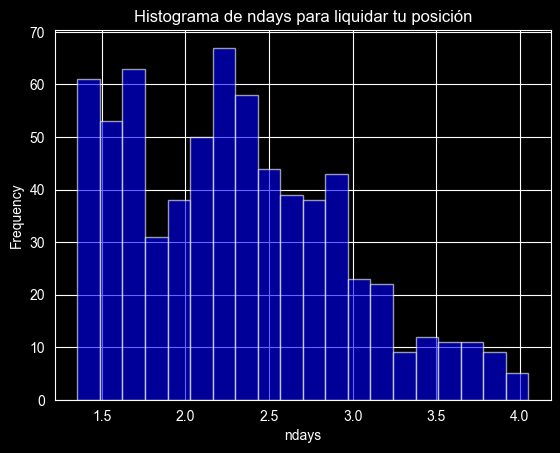

In [31]:
plt.hist(df["Days_to_liquidate"] , bins=20, color='blue', alpha=0.6)
plt.title("Histograma de ndays para liquidar tu posición")
plt.xlabel('ndays')
plt.ylabel('Frequency')
plt.show()

In [32]:
df['spread %'] = (df['Ask'] - df['Bid'] / ((df['Ask'] + df['Bid'])/2)) / 100

df['mean'] = df["spread %"].rolling(datos).mean()
df['sigma'] = df["spread %"].rolling(datos).std()

z = norm.ppf(conf)

df['lvar'] = df["VaR_99"] - 0.5*(df['mean'] + z * df['sigma'])

df['lvar_USD'] = df['lvar'] * df["Position_Value"]

df_2022 = df[df["Date"].dt.year == 2022]
df_2022[["Date", "lvar_USD"]]

,Date,lvar_USD
505,2022-01-03,-25698.4297
506,2022-01-04,-25026.1585
507,2022-01-05,-25919.7260
508,2022-01-06,-25639.6127
509,2022-01-07,-26029.8675
...,...,...
751,2022-12-23,-49128.4889
752,2022-12-27,-51080.0744
753,2022-12-28,-41049.8463
754,2022-12-29,-37284.8490


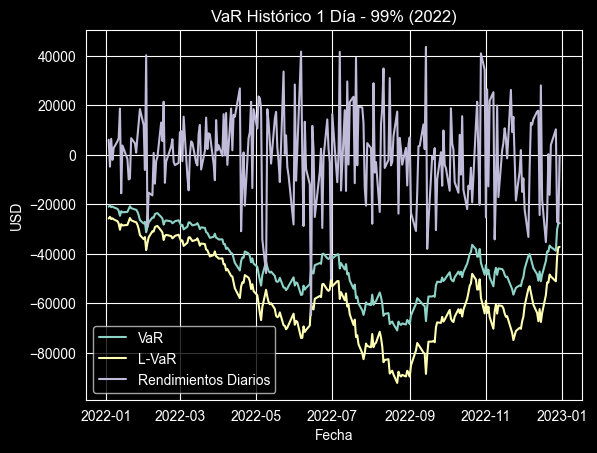

In [33]:
plt.figure()
plt.plot(df_2022["Date"], df_2022["VaR_USD"], label='VaR')
plt.plot(df_2022["Date"], df_2022["lvar_USD"], label = 'L-VaR')
plt.plot(df_2022["Date"], df_2022["Return"] * df_2022["Position_Value"], label = "Rendimientos Diarios")
plt.title("VaR Histórico 1 Día - 99% (2022)")
plt.xlabel("Fecha")
plt.ylabel("USD")
plt.legend()
plt.show()

En este ejercicio se calculó el VaR histórico con un nivel de confianza del 99% para el año 2022, obteniéndose una estimación cercana al 13.5% diario. Este resultado puede parecer elevado; sin embargo, es consistente con la alta volatilidad observada en el mercado de Henry Hub Natural Gas durante 2022, periodo caracterizado por fuertes fluctuaciones y movimientos extremos en los precios.

In [34]:
violaciones = df_2022["Return"] < df_2022["VaR_99"]
num_violaciones = violaciones.sum()
porcentaje = num_violaciones / len(df_2022)

print("Frecuencia de violaciones (%):", porcentaje * 100)

Frecuencia de violaciones (%): 1.1952191235059761


En este último chunk se calculó el número de veces que la pérdida observada en el día fue mayor a la pérdida esperada con el cáluclo de VaR. Podemos observar que solo cerca del 1.19% de las veces sucedió esto, lo cual se muestra ligeramenta arriba de nuestro nivel de confianza del 99%.

Se concluye que el modelo es congruente con el nivel de confianza establecido. Si el número de violaciones hubiese sido superior al esperado, esto sugeriría que el VaR histórico subestimó el riesgo durante el periodo analizado y no logró capturar completamente la magnitud de los eventos extremos.